In [29]:
import pandas

ACCELERATION_NOISE_THRESHOLD = 1.0

df = pandas.read_csv('Raw Data.csv')
df

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,-0.000141,0.081872,-0.055213,0.071132,0.121702
1,0.009856,-0.048625,-0.027615,0.068886,0.088726
2,0.019854,-0.070803,-0.004574,0.047379,0.085316
3,0.029852,0.035135,-0.004842,-0.069368,0.077909
4,0.039850,0.048807,-0.033459,-0.114005,0.128448
...,...,...,...,...,...
3235,32.342933,-0.031662,-0.012572,0.048071,0.058918
3236,32.352931,0.010792,0.022236,-0.049985,0.055762
3237,32.362929,-0.017933,0.043227,-0.274667,0.278625
3238,32.372927,-0.047209,0.001571,-0.312831,0.316377


<AxesSubplot:xlabel='Time (s)'>

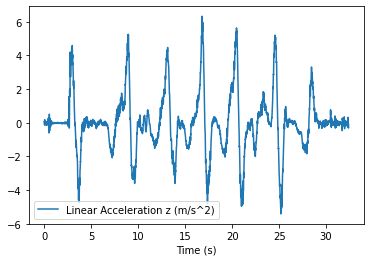

In [30]:
df.plot.line(x="Time (s)", y="Linear Acceleration z (m/s^2)")

### Removing noise - too high rate of change of acceleration changed to 0


Change:  5.093700982899775
Z-acc replaced:  0.0

Change:  28.77752293117386
Z-acc replaced:  0.0

Change:  1.1342521022493246
Z-acc replaced:  0.0

Change:  2.748603170935114
Z-acc replaced:  0.0

Change:  2.541173399028721
Z-acc replaced:  0.0

Change:  2.896269877880703
Z-acc replaced:  0.0

Change:  5.233299839738438
Z-acc replaced:  0.0

Change:  1.3452078880804526
Z-acc replaced:  0.0

Change:  14.25412479546186
Z-acc replaced:  0.0

Change:  3.683873673066647
Z-acc replaced:  0.0

Change:  2.0524369818734844
Z-acc replaced:  0.0

Change:  1.813042095966182
Z-acc replaced:  0.0

Change:  1.1097442370220265
Z-acc replaced:  0.0

Change:  4.602669992195647
Z-acc replaced:  0.0

Change:  2.021902619893765
Z-acc replaced:  0.0

Change:  1.4339280667274306
Z-acc replaced:  0.0

Change:  14.289750789964703
Z-acc replaced:  0.0

Change:  15.987042676942572
Z-acc replaced:  0.0

Change:  2.0329352150703164
Z-acc replaced:  0.0

Change:  1.9576246154205852
Z-acc replaced:  0.0

Change:  1

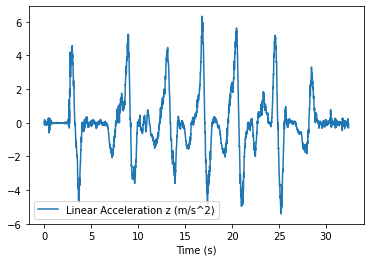

In [31]:
def filter_noise(dataframe):
    changes = dataframe.pct_change()["Linear Acceleration z (m/s^2)"]
    for i, change in changes.items():
        if change > ACCELERATION_NOISE_THRESHOLD:
            print("\nChange: ", change)
            dataframe["Linear Acceleration z (m/s^2)"][i] = 0.0
            print("Z-acc replaced: ", dataframe["Linear Acceleration z (m/s^2)"][i])
    dataframe.plot.line(x="Time (s)", y="Linear Acceleration z (m/s^2)")
    return dataframe

filtered_df = filter_noise(df)

### Calculating velocity and distance from z-axis acceleration and timesteps

In [32]:
def get_velocity(acceleration: float, V0: float, delta_t: float):
    # a = (V1-V0) / t
    # V1 = a*t + V0
    return acceleration * delta_t + V0

def get_distance(delta_V: float, delta_t: float):
    # V = s/t
    # s = V*t
    return delta_V * delta_t

def get_energy_spent(mass: float, distance: float, acceleration: float):
    # A = F*s
    # F = m*a
    return mass * acceleration * distance

mass = 5
previous_time = 0.0
previous_velocity = 0.0
total_distance = 0.0
total_energy = 0.0
velocity_vec = [[]]
distance_vec = [[]]
energy_vec = [[]]

for index, row in filtered_df.iterrows():
    timestep = row["Time (s)"] - previous_time

    velocity = get_velocity(row["Linear Acceleration z (m/s^2)"], previous_velocity, timestep)
    velocity_vec.append([row["Time (s)"], velocity])

    distance_step = abs(get_distance(velocity, timestep))
    total_distance += distance_step
    distance_vec.append([row["Time (s)"], total_distance])

    energy_step = abs(get_energy_spent(mass, distance_step, row["Linear Acceleration z (m/s^2)"]))
    total_energy += energy_step
    energy_vec.append([row["Time (s)"], total_energy])

    previous_velocity = velocity
    previous_time = row["Time (s)"]

### Plotting

Distance is (m):  20.143116922949247
Energy is (J):  123.4449103338095


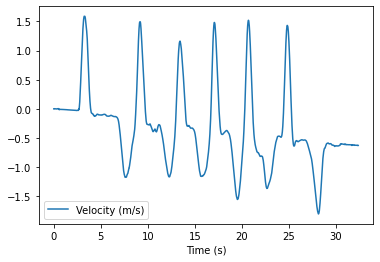

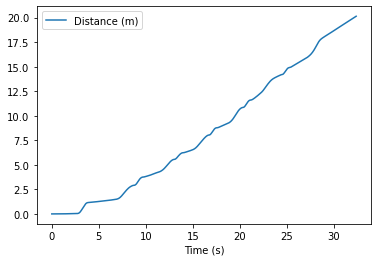

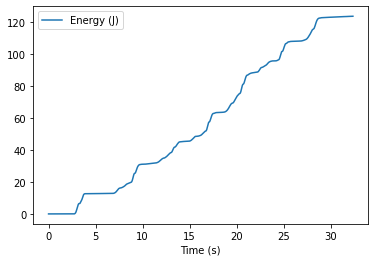

In [33]:
df_velocity = pandas.DataFrame(velocity_vec, columns=["Time (s)", "Velocity (m/s)"])
df_velocity.plot.line(x="Time (s)", y="Velocity (m/s)")
df_distance = pandas.DataFrame(distance_vec, columns=["Time (s)", "Distance (m)"])
df_distance.plot.line(x="Time (s)", y="Distance (m)")
df_distance = pandas.DataFrame(energy_vec, columns=["Time (s)", "Energy (J)"])
df_distance.plot.line(x="Time (s)", y="Energy (J)")
print("Distance is (m): ", total_distance)
print("Energy is (J): ", total_energy)